# Aircraft Engine Remaining Useful Life (RUL) Prediction
Author: Surya Vamshi Sriperambudooru

---

##  Project Overview

This notebook demonstrates multiple machine learning approaches to predict the Remaining Useful Life (RUL) of aircraft engines using sensor data from the NASA C-MAPSS dataset. We implement classical ML models (Random Forest, SVR, Linear Regression) and a deep learning hybrid (CNN+LSTM), and compare their predictive performance.

---

##  Data Understanding and Loading

### About the Data

- **Source:** NASA C-MAPSS Turbofan Engine Degradation Simulation Data Set
- **Columns:** unit number, time in cycles, 3 operational settings, 21 sensor measurements

### Load the Data

```python
import pandas as pd

# Define columns as per the C-MAPSS dataset documentation
columns = ['unit_number', 'time_in_cycles', 'op_set_1', 'op_set_2', 'op_set_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load training data (adjust filename as needed)
train = pd.read_csv('train_FD003.txt', sep='\s+', header=None, names=columns)

# Preview
train.head()



In [1]:
import os
os.getcwd()


'/Users/shourya/Desktop/After Grad/JOB Hunt 2025'

In [3]:
import pandas as pd

# Define columns as per the C-MAPSS dataset documentation
columns = ['unit_number', 'time_in_cycles', 'op_set_1', 'op_set_2', 'op_set_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load training data (adjust filename as needed)
train = pd.read_csv('train_FD003.txt', sep='\s+', header=None, names=columns)

# Preview
train.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


# Ridge Regression

## FD001 Linear Regression



In [6]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define columns
column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = ['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']

# Normalize
sensor_data = train_df[sensor_cols]
sensor_min, sensor_max = sensor_data.min(), sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove unused sensors and combine
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Windowing
TW = 40
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i-TW:i-1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X, y = np.array(features), np.array(targets)



## Model Training & Evaluation


Mean RMSE over 5 runs: 33.6405
Standard deviation of RMSE: 0.0000


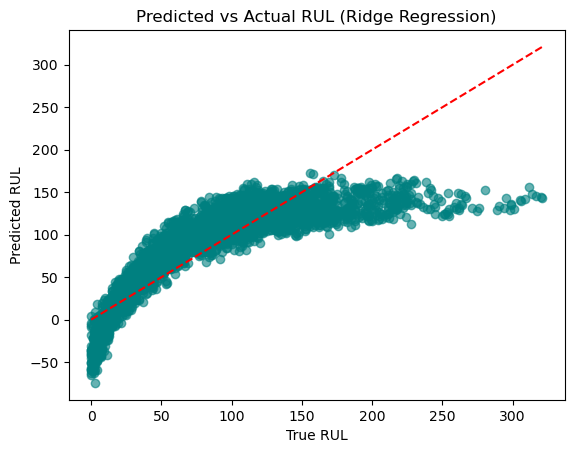

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_alpha = 100.0
ridge_model = Ridge(alpha=best_alpha)
rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
mean_rmse, std_rmse = np.mean(rmse_values), np.std(rmse_values)
print(f"Mean RMSE over 5 runs: {mean_rmse:.4f}")
print(f"Standard deviation of RMSE: {std_rmse:.4f}")
# Plot Actual vs Predicted
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Ridge Regression)")
plt.show()


## Test Set Evaluation


Test RMSE over 5 runs: 29.7764
Standard deviation of Test RMSE: 0.0000


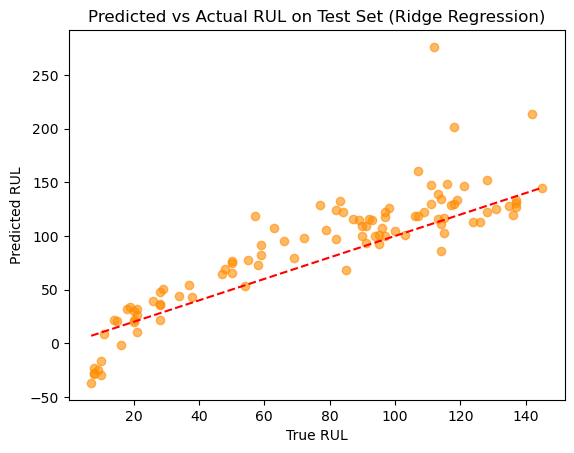

In [11]:
# Load and process test data
test_df = pd.read_csv("test_FD001.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)
true_rul = pd.read_csv("RUL_FD001.txt", sep=' ', header=None).dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare features
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Test model
test_rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_test_pred = ridge_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
    test_rmse_values.append(rmse_test)
mean_test_rmse, std_test_rmse = np.mean(test_rmse_values), np.std(test_rmse_values)
print(f"Test RMSE over 5 runs: {mean_test_rmse:.4f}")
print(f"Standard deviation of Test RMSE: {std_test_rmse:.4f}")

plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Ridge Regression)")
plt.show()


## FD002 Dataset


In [12]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define columns
column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df = pd.read_csv("train_FD002.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = ['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']

# Normalize
sensor_data = train_df[sensor_cols]
sensor_min, sensor_max = sensor_data.min(), sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove unused sensors and combine
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Windowing
TW = 40
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i-TW:i-1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X, y = np.array(features), np.array(targets)



## Model Training & Evaluation

Mean RMSE over 5 runs: 38.3264
Standard deviation of RMSE: 0.0000


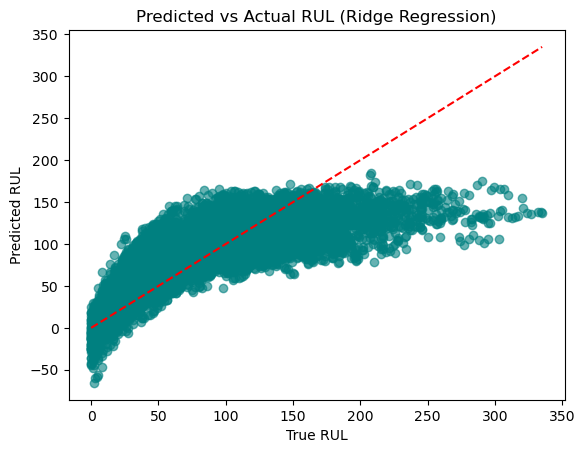

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_alpha = 100.0
ridge_model = Ridge(alpha=best_alpha)
rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
mean_rmse, std_rmse = np.mean(rmse_values), np.std(rmse_values)
print(f"Mean RMSE over 5 runs: {mean_rmse:.4f}")
print(f"Standard deviation of RMSE: {std_rmse:.4f}")
# Plot Actual vs Predicted
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Ridge Regression)")
plt.show()


## Test Set Evaluation


Test RMSE over 5 runs: 31.6818
Standard deviation of Test RMSE: 0.0000


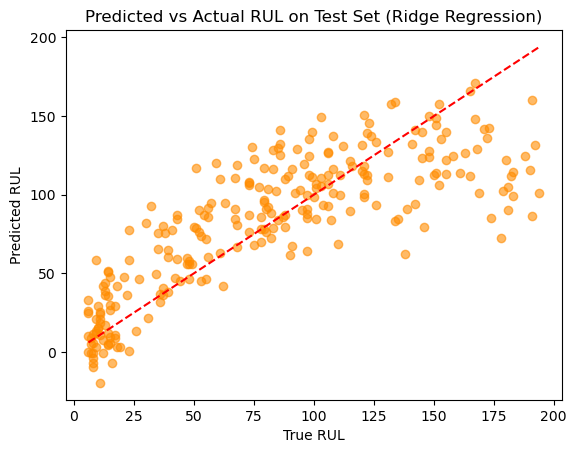

In [15]:
# Load and process test data
test_df = pd.read_csv("test_FD002.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)
true_rul = pd.read_csv("RUL_FD002.txt", sep=' ', header=None).dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare features
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Test model
test_rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_test_pred = ridge_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
    test_rmse_values.append(rmse_test)
mean_test_rmse, std_test_rmse = np.mean(test_rmse_values), np.std(test_rmse_values)
print(f"Test RMSE over 5 runs: {mean_test_rmse:.4f}")
print(f"Standard deviation of Test RMSE: {std_test_rmse:.4f}")

plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Ridge Regression)")
plt.show()


## FD003 Dataset

In [16]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define columns
column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df = pd.read_csv("train_FD003.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = ['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']

# Normalize
sensor_data = train_df[sensor_cols]
sensor_min, sensor_max = sensor_data.min(), sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove unused sensors and combine
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Windowing
TW = 40
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i-TW:i-1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X, y = np.array(features), np.array(targets)



## Model Training & Evaluation

Mean RMSE over 5 runs: 53.9055
Standard deviation of RMSE: 0.0000


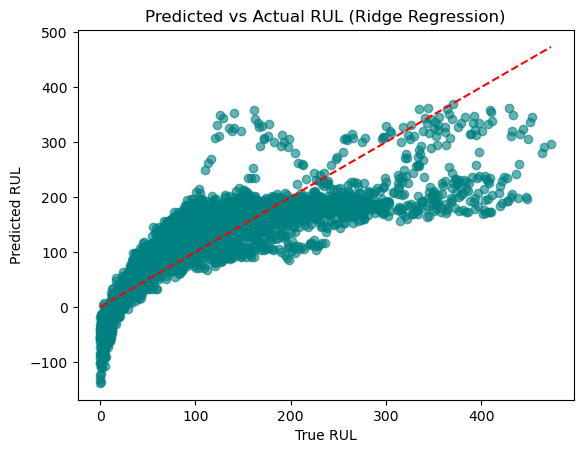

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_alpha = 100.0
ridge_model = Ridge(alpha=best_alpha)
rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
mean_rmse, std_rmse = np.mean(rmse_values), np.std(rmse_values)
print(f"Mean RMSE over 5 runs: {mean_rmse:.4f}")
print(f"Standard deviation of RMSE: {std_rmse:.4f}")
# Plot Actual vs Predicted
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Ridge Regression)")
plt.show()


## Test Set Evaluation

Test RMSE over 5 runs: 40.8188
Standard deviation of Test RMSE: 0.0000


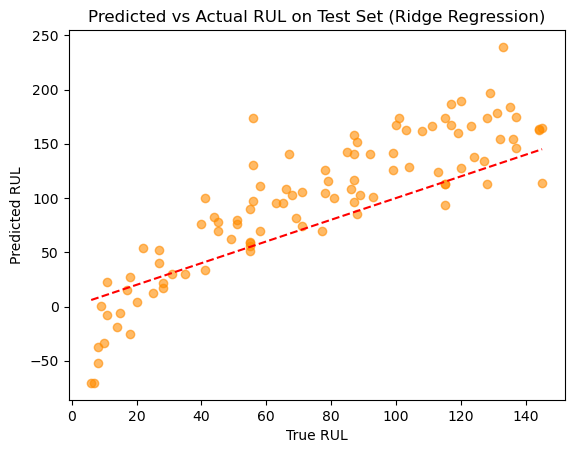

In [18]:
# Load and process test data
test_df = pd.read_csv("test_FD003.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)
true_rul = pd.read_csv("RUL_FD003.txt", sep=' ', header=None).dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare features
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Test model
test_rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_test_pred = ridge_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
    test_rmse_values.append(rmse_test)
mean_test_rmse, std_test_rmse = np.mean(test_rmse_values), np.std(test_rmse_values)
print(f"Test RMSE over 5 runs: {mean_test_rmse:.4f}")
print(f"Standard deviation of Test RMSE: {std_test_rmse:.4f}")

plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Ridge Regression)")
plt.show()


## FD004 Dataset

In [7]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define columns
column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + [f'sensor_measurement_{i}' for i in range(1, 22)]
train_df = pd.read_csv("train_FD004.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = ['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19']

# Normalize
sensor_data = train_df[sensor_cols]
sensor_min, sensor_max = sensor_data.min(), sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove unused sensors and combine
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Windowing
TW = 40
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i-TW:i-1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X, y = np.array(features), np.array(targets)



## Model Training & Evaluation

Mean RMSE over 5 runs: 56.5306
Standard deviation of RMSE: 0.0000


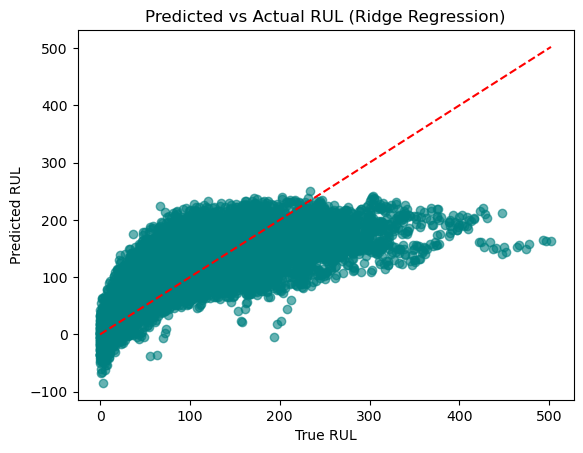

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
best_alpha = 100.0
ridge_model = Ridge(alpha=best_alpha)
rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_values.append(rmse)
mean_rmse, std_rmse = np.mean(rmse_values), np.std(rmse_values)
print(f"Mean RMSE over 5 runs: {mean_rmse:.4f}")
print(f"Standard deviation of RMSE: {std_rmse:.4f}")
# Plot Actual vs Predicted
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Ridge Regression)")
plt.show()


## Test Set Evaluation

Test RMSE over 5 runs: 42.2027
Standard deviation of Test RMSE: 0.0000


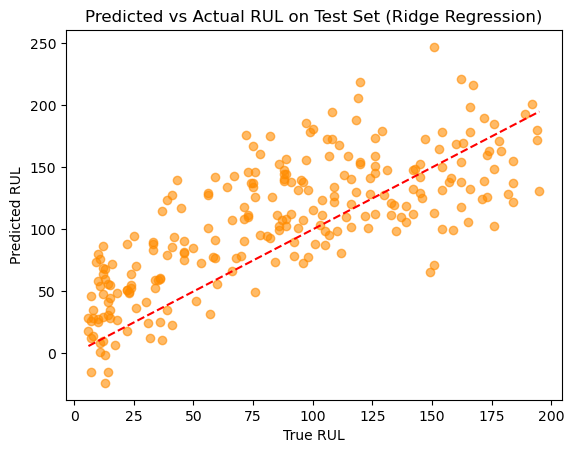

In [9]:
# Load and process test data
test_df = pd.read_csv("test_FD004.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)
true_rul = pd.read_csv("RUL_FD004.txt", sep=' ', header=None).dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare features
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Test model
test_rmse_values = []
for i in range(5):
    ridge_model.fit(X_train, y_train)
    y_test_pred = ridge_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
    test_rmse_values.append(rmse_test)
mean_test_rmse, std_test_rmse = np.mean(test_rmse_values), np.std(test_rmse_values)
print(f"Test RMSE over 5 runs: {mean_test_rmse:.4f}")
print(f"Standard deviation of Test RMSE: {std_test_rmse:.4f}")

plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Ridge Regression)")
plt.show()


# Random Forest

## FD001 - Data Preparation & Feature Engineering

In [19]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns & sensors to remove (uninformative)
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Min-max normalize sensor data to [-1, 1] using training data only
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove uninformative sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with basic columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Calculate Remaining Useful Life (RUL)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Time window feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)



## Model Training & Evaluation

Validation RMSE: 32.6202


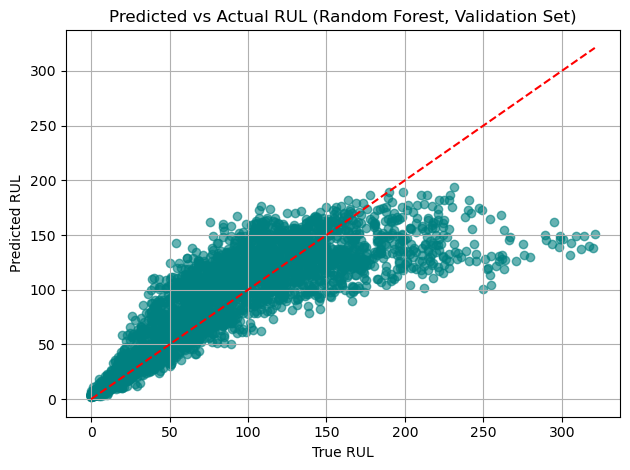

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=42)

# Validation: fit & predict (you can do multiple runs if you want)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot validation predictions
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Random Forest, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 23.0173


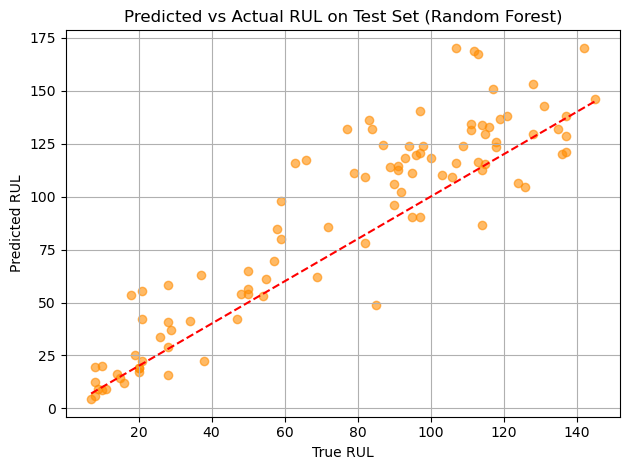

In [21]:
# Load and preprocess test data using train normalization!
test_df = pd.read_csv("test_FD001.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Load ground-truth RUL values for the test set
true_rul = pd.read_csv("RUL_FD001.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot test predictions
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD002 - Data Preparation & Feature Engineering

In [22]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD002.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns & sensors to remove (uninformative)
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Min-max normalize sensor data to [-1, 1] using training data only
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove uninformative sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with basic columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Calculate Remaining Useful Life (RUL)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Time window feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)



## Model Training & Evaluation

Validation RMSE: 36.2204


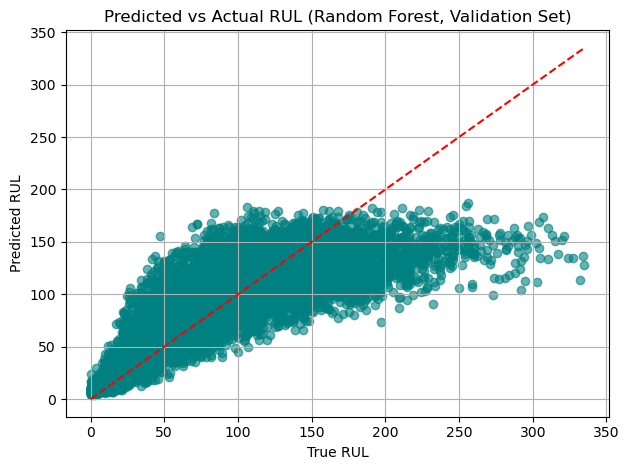

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=42)

# Validation: fit & predict (you can do multiple runs if you want)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot validation predictions
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Random Forest, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 28.4774


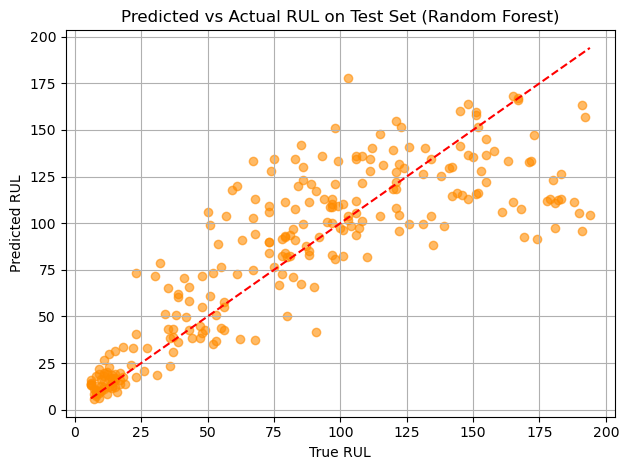

In [25]:
# Load and preprocess test data using train normalization!
test_df = pd.read_csv("test_FD002.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Load ground-truth RUL values for the test set
true_rul = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot test predictions
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD003 - Data Preparation & Feature Engineering

In [10]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD003.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns & sensors to remove (uninformative)
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Min-max normalize sensor data to [-1, 1] using training data only
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove uninformative sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with basic columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Calculate Remaining Useful Life (RUL)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Time window feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)



## Model Training & Evaluation

Validation RMSE: 44.6834


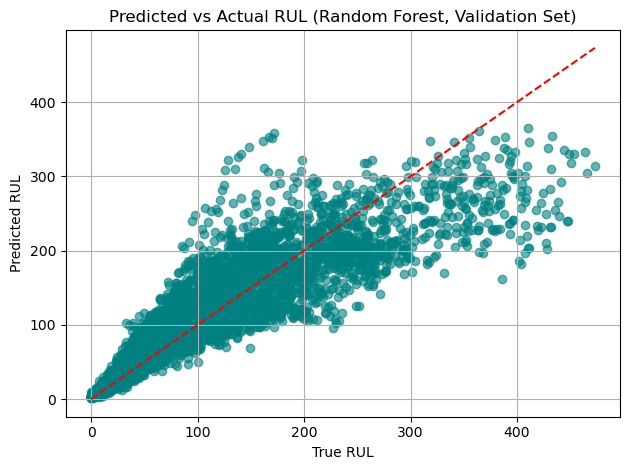

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=42)

# Validation: fit & predict (you can do multiple runs if you want)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot validation predictions
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Random Forest, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 33.0915


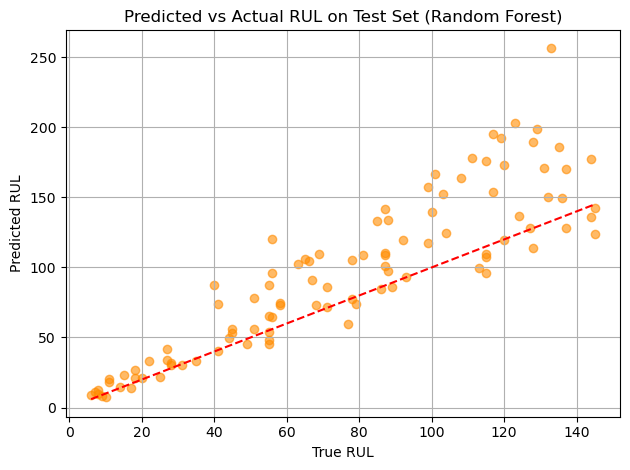

In [12]:
# Load and preprocess test data using train normalization!
test_df = pd.read_csv("test_FD003.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Load ground-truth RUL values for the test set
true_rul = pd.read_csv("RUL_FD003.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot test predictions
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD004 - Data Preparation & Feature Engineering

In [26]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD004.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns & sensors to remove (uninformative)
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Min-max normalize sensor data to [-1, 1] using training data only
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove uninformative sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with basic columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Calculate Remaining Useful Life (RUL)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Time window feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)



## Model Training & Evaluation

Validation RMSE: 50.4060


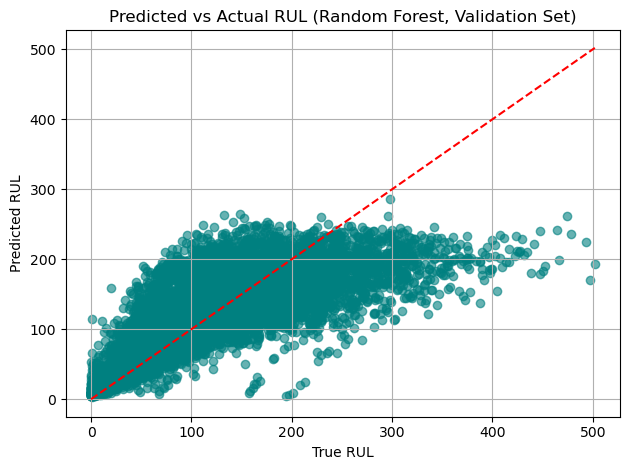

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train Random Forest
rf_model = RandomForestRegressor(n_estimators=50, max_depth=30, random_state=42)

# Validation: fit & predict (you can do multiple runs if you want)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot validation predictions
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (Random Forest, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 35.2479


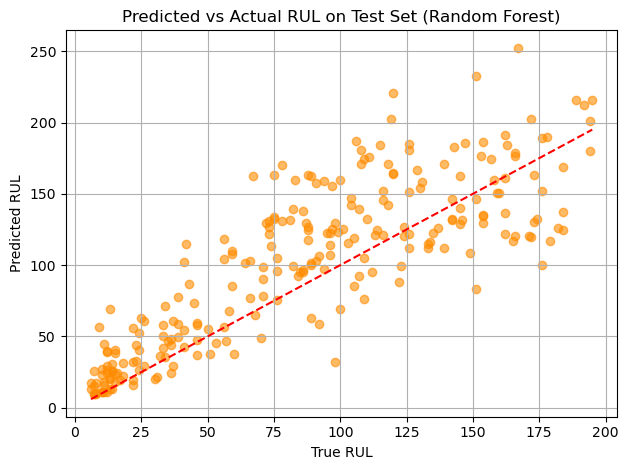

In [28]:
# Load and preprocess test data using train normalization!
test_df = pd.read_csv("test_FD004.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)

# Load ground-truth RUL values for the test set
true_rul = pd.read_csv("RUL_FD004.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = rf_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot test predictions
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


#  Support Vector Regression (SVR)

## FD001 - Data Preparation & Standardization

In [30]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensor columns & sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Normalize sensor data to [-1, 1]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove specified sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with key columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Compute RUL (Remaining Useful Life)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Windowed feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)

# Standardize features for SVR (important for kernel methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model Training & Evaluation

Validation RMSE: 28.3891


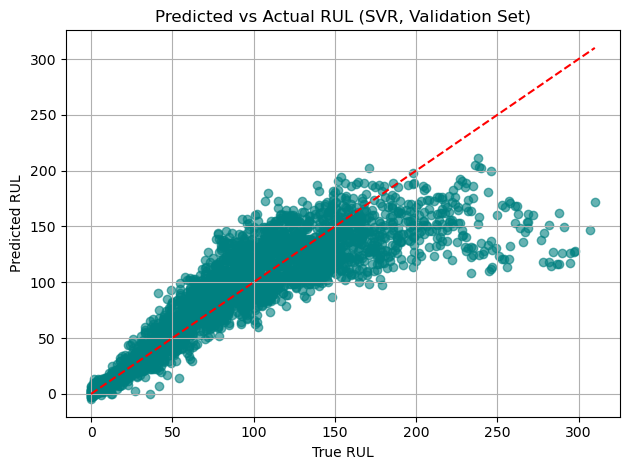

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2)

# Define & train SVR
svr_model = SVR(kernel='rbf', C=50, epsilon=1, gamma='scale')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot predictions vs actuals
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (SVR, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 22.4002


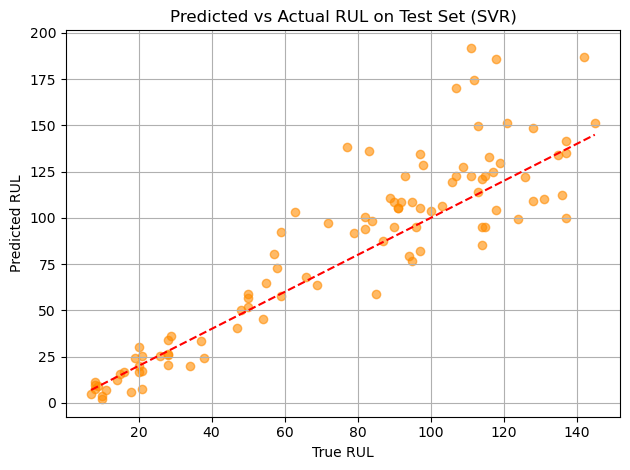

In [32]:
# --- Load and process test data ---
test_df = pd.read_csv("test_FD001.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean test sensor data using *train* min/max
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD001.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = svr_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot Actual vs Predicted RUL for test set
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD002 - Data Preparation & Standardization

In [33]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD002.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensor columns & sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Normalize sensor data to [-1, 1]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove specified sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with key columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Compute RUL (Remaining Useful Life)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Windowed feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)

# Standardize features for SVR (important for kernel methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model Training & Evaluation

Validation RMSE: 42.6558


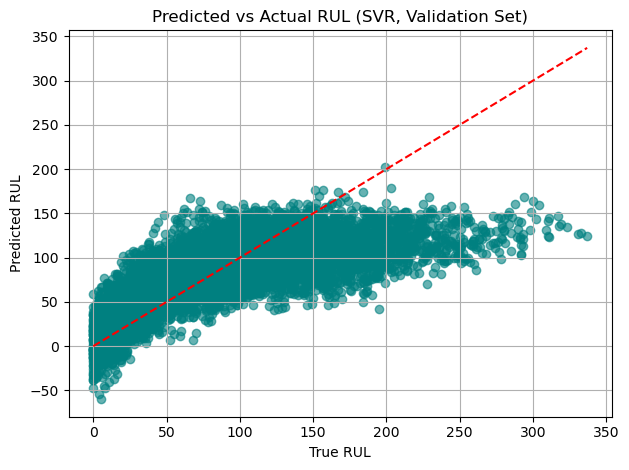

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2)

# Define & train SVR
svr_model = SVR(kernel='rbf', C=50, epsilon=1, gamma='scale')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot predictions vs actuals
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (SVR, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 36.2192


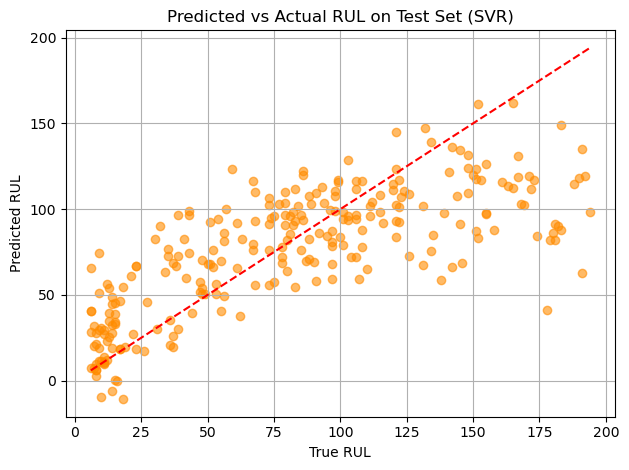

In [36]:
# --- Load and process test data ---
test_df = pd.read_csv("test_FD002.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean test sensor data using *train* min/max
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = svr_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot Actual vs Predicted RUL for test set
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD003 - Data Preparation & Standardization

In [37]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD003.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensor columns & sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Normalize sensor data to [-1, 1]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove specified sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with key columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Compute RUL (Remaining Useful Life)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Windowed feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)

# Standardize features for SVR (important for kernel methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model Training & Evaluation

Validation RMSE: 45.5502


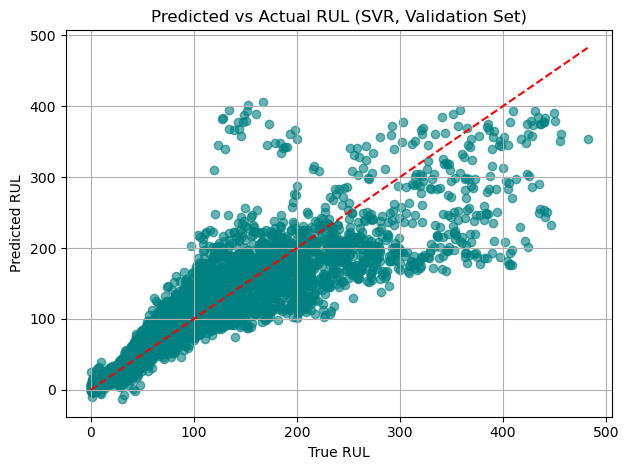

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2)

# Define & train SVR
svr_model = SVR(kernel='rbf', C=50, epsilon=1, gamma='scale')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot predictions vs actuals
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (SVR, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 28.4356


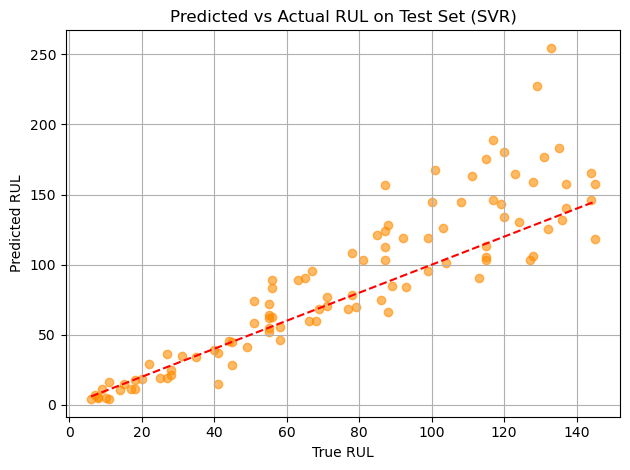

In [39]:
# --- Load and process test data ---
test_df = pd.read_csv("test_FD003.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean test sensor data using *train* min/max
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD003.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = svr_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot Actual vs Predicted RUL for test set
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()


## FD004 - Data Preparation & Standardization

In [2]:
import pandas as pd
import numpy as np

# Define column names
column_names = ['unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load training data
train_df = pd.read_csv("train_FD004.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Sensor columns & sensors to remove
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19'
]

# Normalize sensor data to [-1, 1]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1

# Remove specified sensors
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)
sensor_data_clean.columns = [col + "_norm" for col in sensor_data_clean.columns]

# Combine with key columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)

# Compute RUL (Remaining Useful Life)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']

# Windowed feature engineering
TW = 40
features = []
targets = []
sensor_feature_cols = sensor_data_clean.columns
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values.flatten()
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)
y = np.array(targets)

# Standardize features for SVR (important for kernel methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Model Training & Evaluation

Validation RMSE: 61.4112


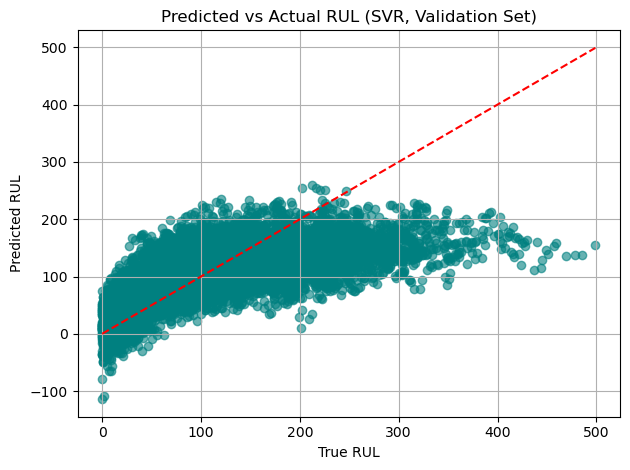

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2)

# Define & train SVR
svr_model = SVR(kernel='rbf', C=50, epsilon=1, gamma='scale')
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.4f}")

# Plot predictions vs actuals
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL (SVR, Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE: 42.0305


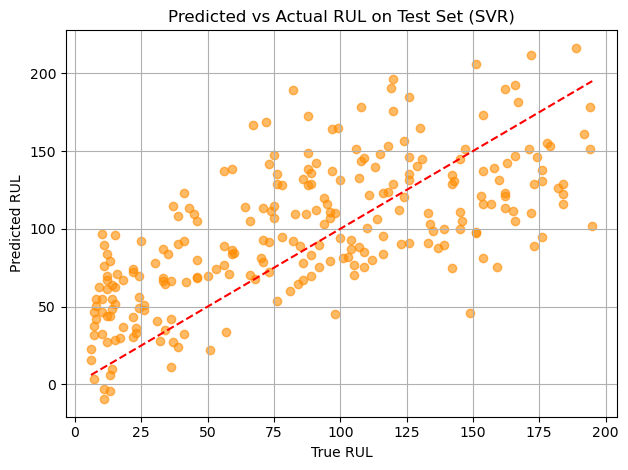

In [4]:
# --- Load and process test data ---
test_df = pd.read_csv("test_FD004.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean test sensor data using *train* min/max
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
sensor_data_test_clean.columns = [col + "_norm" for col in sensor_data_test_clean.columns]

test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Prepare test set features (last available window per unit)
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values.flatten()
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values)).flatten()
    X_test.append(window)
X_test = np.array(X_test)
X_test_scaled = scaler.transform(X_test)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD004.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Predict on test set
y_test_pred = svr_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'], y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

# Plot Actual vs Predicted RUL for test set
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='darkorange')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (SVR)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Multichannel CNN+LSTM (PyTorch)

## Imports and Random Seed

In [41]:
#!pip install torch torchvision torchaudio


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/5b/2b/d36d57c66ff031f93b4fa432e86802f84991477e522adcdffd314454326b/torch-2.7.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/f6/00/bdab236ef19da050290abc2b5203ff9945c84a1f2c7aab73e8e9c8c85669/torchvision-0.22.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/85/a2/52e6760d352584ae1ab139d97647bdc51d1eb7d480b688fe69c72616c956/torchaudio-2.7.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.10.0 from https://files.pythonhosted.org/packages/b5/00/d631e67a838026495268c2f6884f3711a15a9a2a96cd244fdaea53b823fb/typing_extensions-4.14.1-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd

In [43]:
#!pip install --upgrade typing_extensions


In [45]:
#!pip install --upgrade --force-reinstall "typing_extensions>=4.7.0"


  Obtaining dependency information for typing_extensions>=4.7.0 from https://files.pythonhosted.org/packages/b5/00/d631e67a838026495268c2f6884f3711a15a9a2a96cd244fdaea53b823fb/typing_extensions-4.14.1-py3-none-any.whl.metadata
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.14.1
    Uninstalling typing_extensions-4.14.1:
      Successfully uninstalled typing_extensions-4.14.1


In [1]:
#import torch
#print(torch.__version__)


2.7.1


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
# Set random seed
torch.manual_seed(0)
np.random.seed(0)

## Data Loading & Preprocessing - FD001


In [2]:


# Define column names
column_names = ['unit_number', 'time_in_cycles',
                'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load and clean training data
train_df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns and remove uninformative ones
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18',
    'sensor_measurement_19'
]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)

# Combine cleaned sensor data with other columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Window size (time steps)
TW = 40

# Build sequences for model input
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)  # shape: (N, 40, 14)
y = np.array(targets)

# Reshape for CNN input: (N, C=14, H=40, W=1)
X = np.transpose(X, (0, 2, 1))  # (N, 14, 40)
X = X[..., np.newaxis]          # (N, 14, 40, 1)

# Train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


## Pytorch Dataset and DataLoader

In [3]:

class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RULDataset(X_train, y_train)
val_dataset = RULDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


## Model Run 1: CNN(16,32) + LSTM(32)

In [4]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 32
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 10414.8244, Val Loss: 9900.5606
Epoch 2/30 - Train Loss: 9161.2840, Val Loss: 8873.2285
Epoch 3/30 - Train Loss: 8211.5588, Val Loss: 7984.8263
Epoch 4/30 - Train Loss: 7386.0087, Val Loss: 7202.0342
Epoch 5/30 - Train Loss: 6656.4215, Val Loss: 6508.6735
Epoch 6/30 - Train Loss: 6007.4507, Val Loss: 5891.3578
Epoch 7/30 - Train Loss: 5429.0856, Val Loss: 5339.4299
Epoch 8/30 - Train Loss: 4912.0841, Val Loss: 4843.1791
Epoch 9/30 - Train Loss: 4451.4481, Val Loss: 4402.5383
Epoch 10/30 - Train Loss: 4039.8778, Val Loss: 4010.4024
Epoch 11/30 - Train Loss: 3674.2006, Val Loss: 3658.2321
Epoch 12/30 - Train Loss: 3348.7856, Val Loss: 3341.7060
Epoch 13/30 - Train Loss: 3057.2385, Val Loss: 3060.3055
Epoch 14/30 - Train Loss: 2797.6959, Val Loss: 2810.1410
Epoch 15/30 - Train Loss: 2566.9761, Val Loss: 2590.9718
Epoch 16/30 - Train Loss: 2358.3677, Val Loss: 2385.5089
Epoch 17/30 - Train Loss: 2173.7440, Val Loss: 2211.1568
Epoch 18/30 - Train Loss: 2010.0254, Va

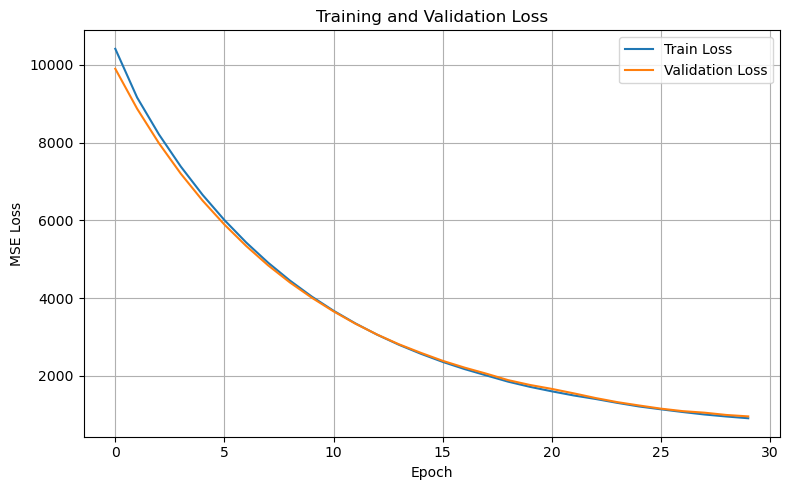

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 21.2091


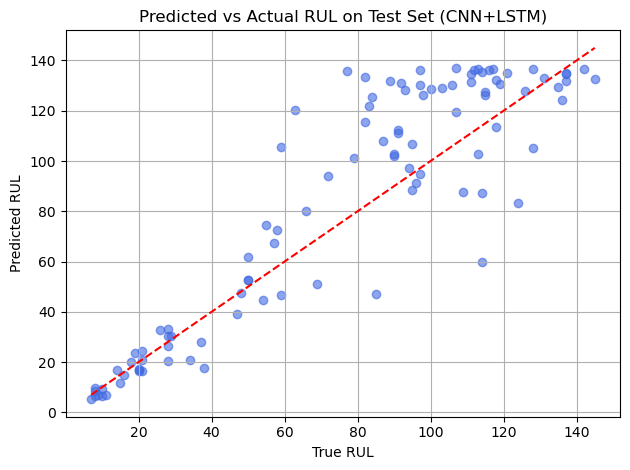

In [6]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD001.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD001.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


##  Model Run 2: CNN(32,64) + LSTM(32)

In [7]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 10392.6063, Val Loss: 9941.3847
Epoch 2/30 - Train Loss: 9188.8644, Val Loss: 8889.4268
Epoch 3/30 - Train Loss: 8217.6189, Val Loss: 7979.4114
Epoch 4/30 - Train Loss: 7372.7469, Val Loss: 7180.7755
Epoch 5/30 - Train Loss: 6627.0943, Val Loss: 6471.7352
Epoch 6/30 - Train Loss: 5965.7092, Val Loss: 5841.6672
Epoch 7/30 - Train Loss: 5376.4155, Val Loss: 5278.2912
Epoch 8/30 - Train Loss: 4851.6733, Val Loss: 4778.9194
Epoch 9/30 - Train Loss: 4385.5717, Val Loss: 4334.9233
Epoch 10/30 - Train Loss: 3972.0732, Val Loss: 3936.1829
Epoch 11/30 - Train Loss: 3604.0525, Val Loss: 3586.6999
Epoch 12/30 - Train Loss: 3277.1634, Val Loss: 3270.5093
Epoch 13/30 - Train Loss: 2988.7854, Val Loss: 2991.2723
Epoch 14/30 - Train Loss: 2732.7388, Val Loss: 2749.2635
Epoch 15/30 - Train Loss: 2506.5704, Val Loss: 2532.5411
Epoch 16/30 - Train Loss: 2308.5837, Val Loss: 2354.8491
Epoch 17/30 - Train Loss: 2136.1373, Val Loss: 2175.6693
Epoch 18/30 - Train Loss: 1986.9456, Va

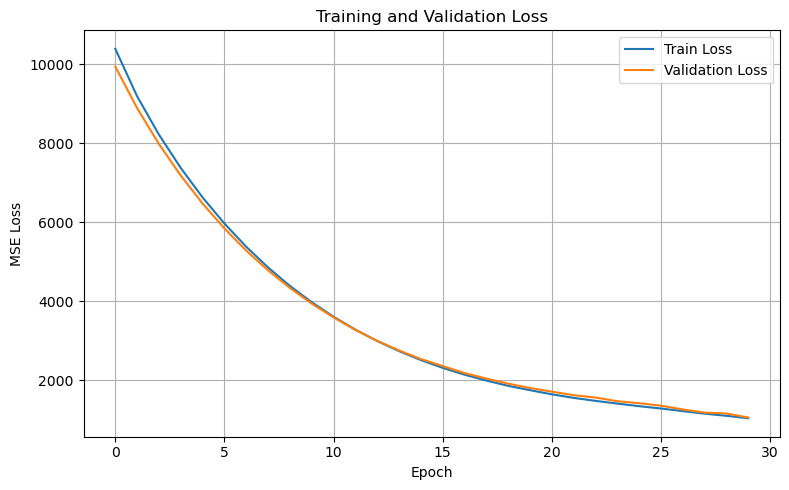

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 17.3546


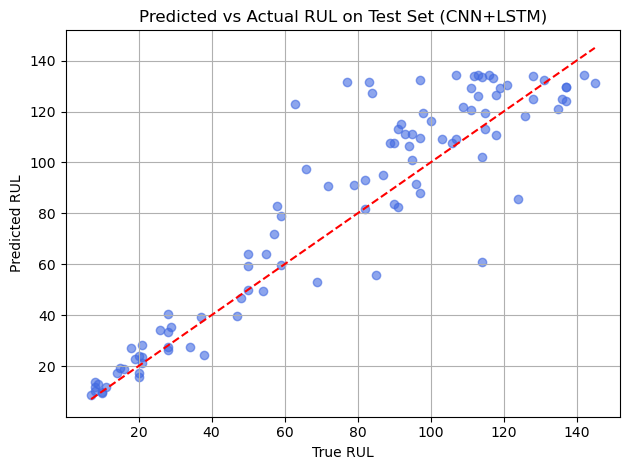

In [9]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD001.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD001.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Data Loading & Preprocessing - FD002


In [10]:


# Define column names
column_names = ['unit_number', 'time_in_cycles',
                'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load and clean training data
train_df = pd.read_csv("train_FD002.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns and remove uninformative ones
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18',
    'sensor_measurement_19'
]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)

# Combine cleaned sensor data with other columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Window size (time steps)
TW = 40

# Build sequences for model input
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)  # shape: (N, 40, 14)
y = np.array(targets)

# Reshape for CNN input: (N, C=14, H=40, W=1)
X = np.transpose(X, (0, 2, 1))  # (N, 14, 40)
X = X[..., np.newaxis]          # (N, 14, 40, 1)

# Train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


## Pytorch Dataset and DataLoader

In [11]:

class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RULDataset(X_train, y_train)
val_dataset = RULDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


## Model Run 1: CNN(16,32) + LSTM(32)

In [14]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 32
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 9638.9174, Val Loss: 8212.1406
Epoch 2/30 - Train Loss: 7297.6467, Val Loss: 6326.3295
Epoch 3/30 - Train Loss: 5745.5180, Val Loss: 5067.6252
Epoch 4/30 - Train Loss: 4737.0130, Val Loss: 4274.8093
Epoch 5/30 - Train Loss: 4129.9274, Val Loss: 3823.3820
Epoch 6/30 - Train Loss: 3803.5183, Val Loss: 3597.9506
Epoch 7/30 - Train Loss: 3655.8011, Val Loss: 3507.5140
Epoch 8/30 - Train Loss: 3603.3825, Val Loss: 3480.1531
Epoch 9/30 - Train Loss: 3589.9773, Val Loss: 3474.0408
Epoch 10/30 - Train Loss: 3587.6237, Val Loss: 3473.0042
Epoch 11/30 - Train Loss: 3508.9478, Val Loss: 2553.0116
Epoch 12/30 - Train Loss: 2084.1840, Val Loss: 1774.3229
Epoch 13/30 - Train Loss: 1688.1088, Val Loss: 1533.5087
Epoch 14/30 - Train Loss: 1497.1169, Val Loss: 1368.5482
Epoch 15/30 - Train Loss: 1348.6300, Val Loss: 1218.4078
Epoch 16/30 - Train Loss: 1247.4891, Val Loss: 1124.1629
Epoch 17/30 - Train Loss: 1183.7620, Val Loss: 1095.3766
Epoch 18/30 - Train Loss: 1133.3198, Val

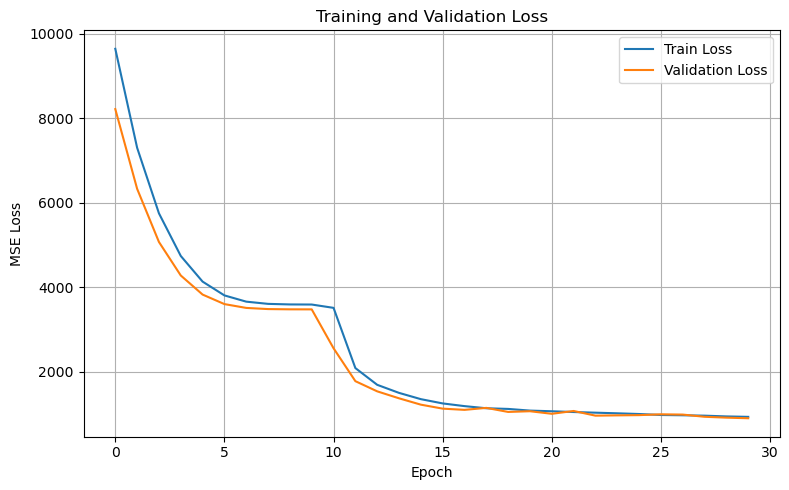

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 29.0184


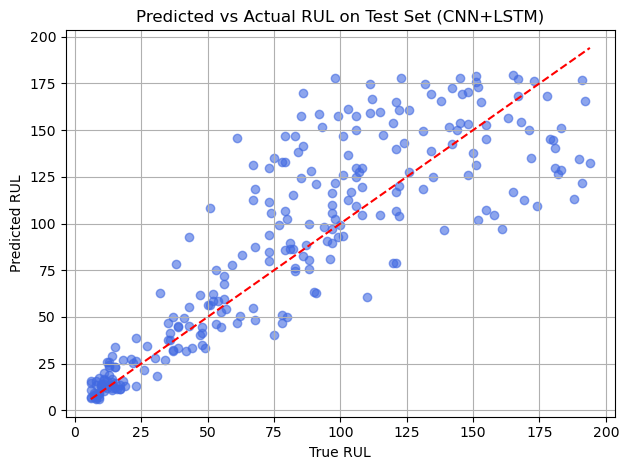

In [16]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD002.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Run 2: CNN(32,64) + LSTM(32)

In [11]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 9626.8808, Val Loss: 8208.2349
Epoch 2/30 - Train Loss: 7297.5640, Val Loss: 6328.8364
Epoch 3/30 - Train Loss: 5748.1213, Val Loss: 5068.1491
Epoch 4/30 - Train Loss: 4738.9908, Val Loss: 4276.1174
Epoch 5/30 - Train Loss: 4131.2103, Val Loss: 3824.6464
Epoch 6/30 - Train Loss: 3805.3932, Val Loss: 3600.0313
Epoch 7/30 - Train Loss: 3657.2135, Val Loss: 3508.4367
Epoch 8/30 - Train Loss: 3604.0624, Val Loss: 3480.5495
Epoch 9/30 - Train Loss: 3590.1759, Val Loss: 3474.0481
Epoch 10/30 - Train Loss: 3587.6733, Val Loss: 3473.0955
Epoch 11/30 - Train Loss: 3587.4543, Val Loss: 3472.9886
Epoch 12/30 - Train Loss: 3587.4495, Val Loss: 3472.9060
Epoch 13/30 - Train Loss: 3587.8570, Val Loss: 3471.2873
Epoch 14/30 - Train Loss: 2199.5553, Val Loss: 1773.4076
Epoch 15/30 - Train Loss: 1696.3673, Val Loss: 1525.6476
Epoch 16/30 - Train Loss: 1487.1630, Val Loss: 1433.0814
Epoch 17/30 - Train Loss: 1340.3419, Val Loss: 1285.6842
Epoch 18/30 - Train Loss: 1241.2905, Val

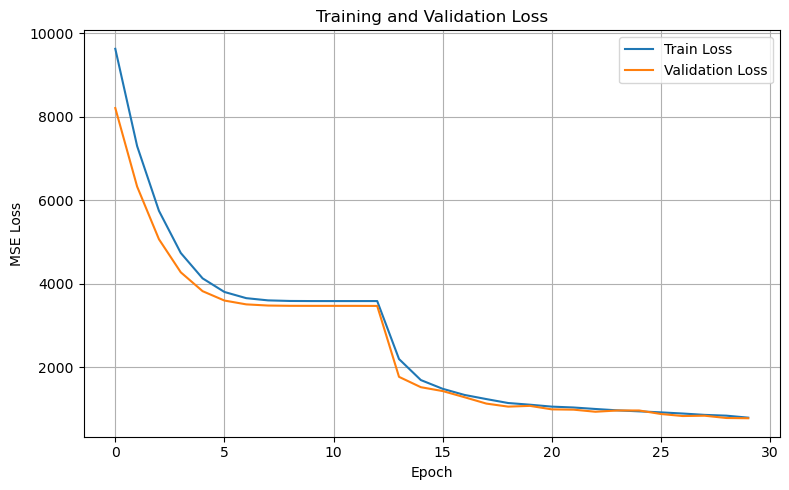

In [12]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 29.3076


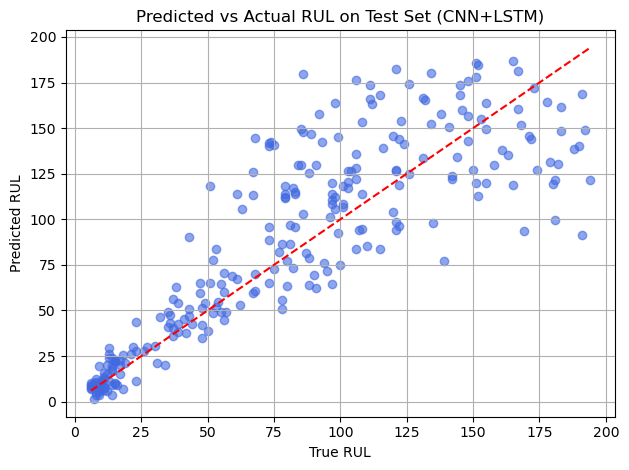

In [13]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD002.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD002.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Data Loading & Preprocessing - FD003


In [17]:


# Define column names
column_names = ['unit_number', 'time_in_cycles',
                'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load and clean training data
train_df = pd.read_csv("train_FD003.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns and remove uninformative ones
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18',
    'sensor_measurement_19'
]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)

# Combine cleaned sensor data with other columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Window size (time steps)
TW = 40

# Build sequences for model input
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)  # shape: (N, 40, 14)
y = np.array(targets)

# Reshape for CNN input: (N, C=14, H=40, W=1)
X = np.transpose(X, (0, 2, 1))  # (N, 14, 40)
X = X[..., np.newaxis]          # (N, 14, 40, 1)

# Train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


## Pytorch Dataset and DataLoader

In [18]:

class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RULDataset(X_train, y_train)
val_dataset = RULDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


## Model Run 1: CNN(16,32) + LSTM(32)

In [19]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 32
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 21571.2813, Val Loss: 19501.5260
Epoch 2/30 - Train Loss: 19465.8860, Val Loss: 17767.8523
Epoch 3/30 - Train Loss: 17782.6999, Val Loss: 16226.3770
Epoch 4/30 - Train Loss: 16282.8443, Val Loss: 14855.2997
Epoch 5/30 - Train Loss: 14940.0069, Val Loss: 13626.7263
Epoch 6/30 - Train Loss: 13730.7125, Val Loss: 12520.6359
Epoch 7/30 - Train Loss: 12635.7700, Val Loss: 11520.8781
Epoch 8/30 - Train Loss: 11645.9996, Val Loss: 10617.2011
Epoch 9/30 - Train Loss: 10747.1593, Val Loss: 9796.1365
Epoch 10/30 - Train Loss: 9931.3520, Val Loss: 9058.3811
Epoch 11/30 - Train Loss: 9190.5357, Val Loss: 8381.0229
Epoch 12/30 - Train Loss: 8513.1596, Val Loss: 7749.9155
Epoch 13/30 - Train Loss: 7900.2644, Val Loss: 7206.4836
Epoch 14/30 - Train Loss: 7341.9996, Val Loss: 6703.8543
Epoch 15/30 - Train Loss: 6832.8591, Val Loss: 6220.9577
Epoch 16/30 - Train Loss: 6369.6730, Val Loss: 5803.7764
Epoch 17/30 - Train Loss: 5950.2501, Val Loss: 5418.1659
Epoch 18/30 - Train Los

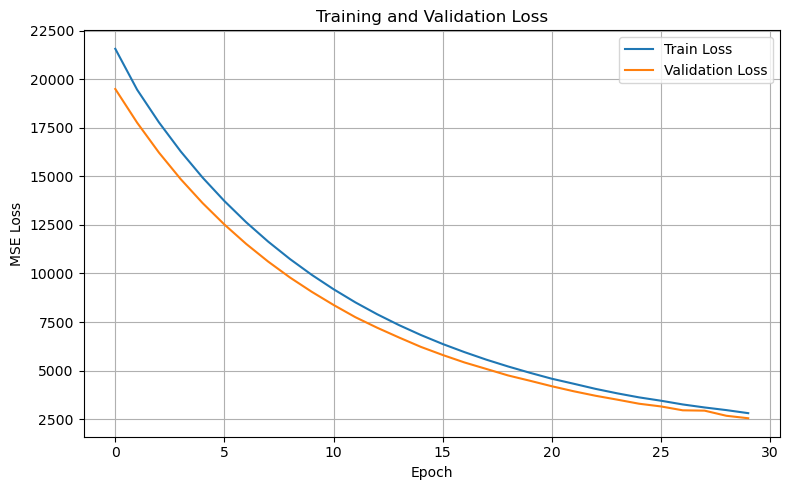

In [20]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 33.9305


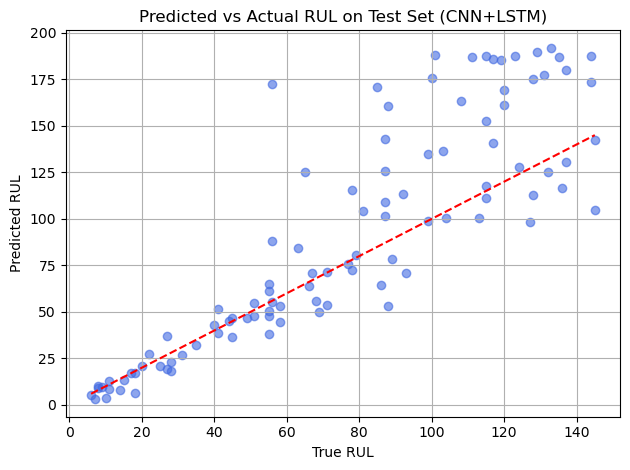

In [21]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD003.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD003.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Run 2: CNN(32,64) + LSTM(32)

In [16]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 21567.0166, Val Loss: 19582.8750
Epoch 2/30 - Train Loss: 19558.0555, Val Loss: 17855.5657
Epoch 3/30 - Train Loss: 17878.3567, Val Loss: 16322.6454
Epoch 4/30 - Train Loss: 16382.4932, Val Loss: 14953.5381
Epoch 5/30 - Train Loss: 15038.9633, Val Loss: 13720.1387
Epoch 6/30 - Train Loss: 13826.3573, Val Loss: 12610.2329
Epoch 7/30 - Train Loss: 12728.0164, Val Loss: 11603.1333
Epoch 8/30 - Train Loss: 11731.9857, Val Loss: 10693.1834
Epoch 9/30 - Train Loss: 10826.2332, Val Loss: 9868.5456
Epoch 10/30 - Train Loss: 10006.2756, Val Loss: 9119.2445
Epoch 11/30 - Train Loss: 9259.6750, Val Loss: 8436.2703
Epoch 12/30 - Train Loss: 8577.0957, Val Loss: 7817.6353
Epoch 13/30 - Train Loss: 7958.0292, Val Loss: 7252.4127
Epoch 14/30 - Train Loss: 7395.3795, Val Loss: 6727.7329
Epoch 15/30 - Train Loss: 6874.7758, Val Loss: 6254.0032
Epoch 16/30 - Train Loss: 6400.4733, Val Loss: 5818.8176
Epoch 17/30 - Train Loss: 5964.4651, Val Loss: 5418.1389
Epoch 18/30 - Train Lo

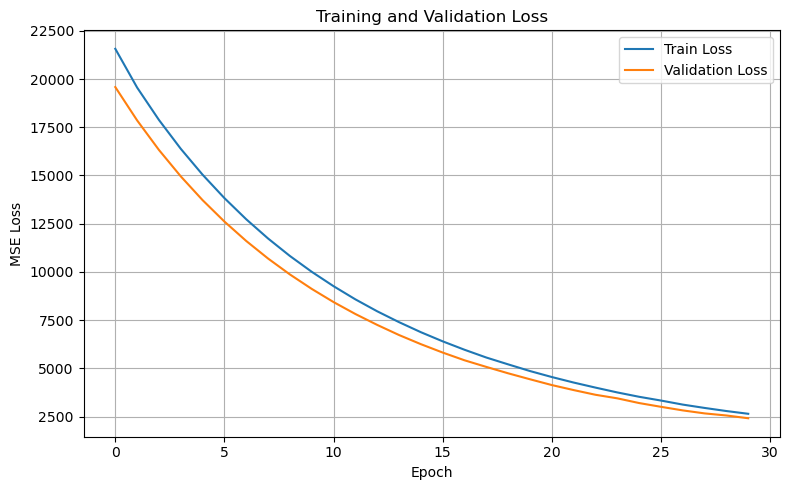

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 34.0634


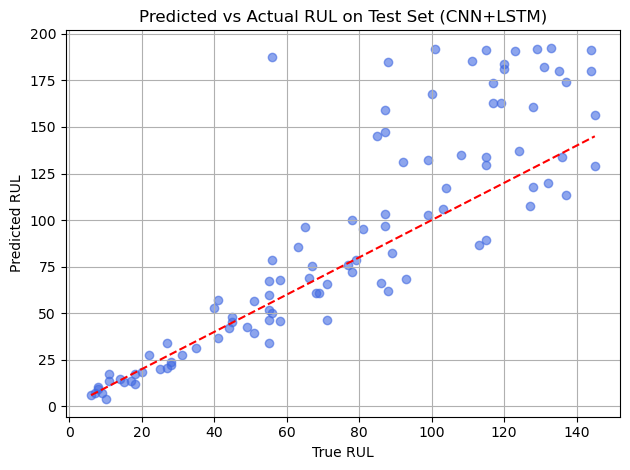

In [18]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD003.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD003.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Data Loading & Preprocessing - FD004


In [22]:


# Define column names
column_names = ['unit_number', 'time_in_cycles',
                'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]

# Load and clean training data
train_df = pd.read_csv("train_FD004.txt", sep=' ', header=None)
train_df.drop(columns=[26, 27], inplace=True)
train_df.columns = column_names

# Select sensor columns and remove uninformative ones
sensor_cols = [col for col in train_df.columns if "sensor" in col]
sensors_to_remove = [
    'sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_6',
    'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18',
    'sensor_measurement_19'
]
sensor_data = train_df[sensor_cols]
sensor_min = sensor_data.min()
sensor_max = sensor_data.max()
sensor_data_normalized = 2 * (sensor_data - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_clean = sensor_data_normalized.drop(columns=sensors_to_remove)

# Combine cleaned sensor data with other columns
train_cleaned = train_df[['unit_number', 'time_in_cycles']].join(sensor_data_clean)
train_cleaned['RUL'] = train_cleaned.groupby('unit_number')['time_in_cycles'].transform('max') - train_cleaned['time_in_cycles']
sensor_feature_cols = sensor_data_clean.columns

# Window size (time steps)
TW = 40

# Build sequences for model input
features, targets = [], []
for unit in train_cleaned['unit_number'].unique():
    unit_data = train_cleaned[train_cleaned['unit_number'] == unit].reset_index(drop=True)
    for i in range(TW, len(unit_data)):
        window = unit_data.loc[i - TW:i - 1, sensor_feature_cols].values
        features.append(window)
        targets.append(unit_data.loc[i, 'RUL'])
X = np.array(features)  # shape: (N, 40, 14)
y = np.array(targets)

# Reshape for CNN input: (N, C=14, H=40, W=1)
X = np.transpose(X, (0, 2, 1))  # (N, 14, 40)
X = X[..., np.newaxis]          # (N, 14, 40, 1)

# Train-val split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)


## Pytorch Dataset and DataLoader

In [23]:

class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = RULDataset(X_train, y_train)
val_dataset = RULDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)


## Model Run 1: CNN(16,32) + LSTM(32)

In [25]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=16, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 32
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 16961.8867, Val Loss: 14652.9431
Epoch 2/30 - Train Loss: 13282.4559, Val Loss: 11660.8637
Epoch 3/30 - Train Loss: 10720.5890, Val Loss: 9563.2172
Epoch 4/30 - Train Loss: 8949.2122, Val Loss: 8158.4216
Epoch 5/30 - Train Loss: 7802.0221, Val Loss: 7301.9500
Epoch 6/30 - Train Loss: 7130.6647, Val Loss: 6842.0205
Epoch 7/30 - Train Loss: 6791.8537, Val Loss: 6640.9612
Epoch 8/30 - Train Loss: 6654.7673, Val Loss: 6576.9620
Epoch 9/30 - Train Loss: 6613.8792, Val Loss: 6565.1963
Epoch 10/30 - Train Loss: 6605.5979, Val Loss: 6565.0440
Epoch 11/30 - Train Loss: 6604.4957, Val Loss: 6565.8327
Epoch 12/30 - Train Loss: 6604.4580, Val Loss: 6565.7450
Epoch 13/30 - Train Loss: 6604.1228, Val Loss: 6564.8065
Epoch 14/30 - Train Loss: 6429.2305, Val Loss: 4832.7485
Epoch 15/30 - Train Loss: 4291.5584, Val Loss: 3874.3187
Epoch 16/30 - Train Loss: 3700.0209, Val Loss: 3467.9378
Epoch 17/30 - Train Loss: 3418.9673, Val Loss: 3356.6777
Epoch 18/30 - Train Loss: 3248.5652

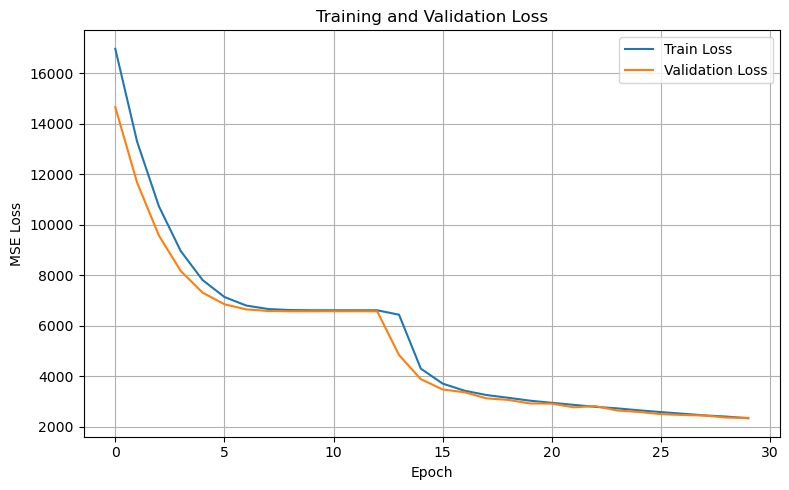

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 39.3851


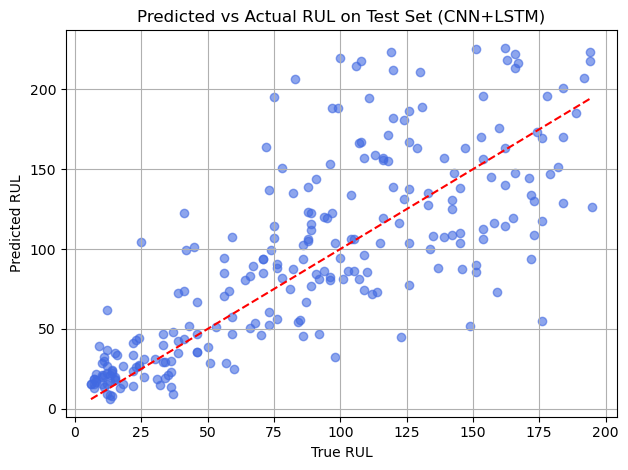

In [27]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD004.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD004.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Model Run 2: CNN(32,64) + LSTM(32)

In [21]:
# === 3. Model ===
class CNN_LSTM_Multichannel(nn.Module):
    def __init__(self, num_channels=14, lstm_hidden_size=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=(3, 1), padding=(1, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 1), padding=(1, 0))
        self.pool2 = nn.MaxPool2d((2, 1))
        self.lstm_input_size = 64
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, 1)
    def forward(self, x):
        x = F.relu(self.conv1(x))  # (N, 32, 40, 1)
        x = self.pool1(x)          # (N, 32, 20, 1)
        x = F.relu(self.conv2(x))  # (N, 64, 20, 1)
        x = self.pool2(x)          # (N, 64, 10, 1)
        x = x.squeeze(-1)          # (N, 64, 10)
        x = x.permute(0, 2, 1)     # (N, 10, 64)
        output, _ = self.lstm(x)   # (N, 10, 32)
        x = output[:, -1, :]       # (N, 32)
        return self.fc(x).squeeze()


## Training Loop

Epoch 1/30 - Train Loss: 17090.9446, Val Loss: 14846.0323
Epoch 2/30 - Train Loss: 13504.3400, Val Loss: 11891.8297
Epoch 3/30 - Train Loss: 10946.7718, Val Loss: 9773.6752
Epoch 4/30 - Train Loss: 9148.5797, Val Loss: 8334.9266
Epoch 5/30 - Train Loss: 7953.5157, Val Loss: 7421.0656
Epoch 6/30 - Train Loss: 7226.3141, Val Loss: 6908.3643
Epoch 7/30 - Train Loss: 6841.4316, Val Loss: 6669.0503
Epoch 8/30 - Train Loss: 6674.5025, Val Loss: 6585.5869
Epoch 9/30 - Train Loss: 6618.8840, Val Loss: 6566.0658
Epoch 10/30 - Train Loss: 6606.1299, Val Loss: 6564.9909
Epoch 11/30 - Train Loss: 6604.5788, Val Loss: 6565.6383
Epoch 12/30 - Train Loss: 6604.5119, Val Loss: 6565.5687
Epoch 13/30 - Train Loss: 6604.2243, Val Loss: 6483.2568
Epoch 14/30 - Train Loss: 4813.4348, Val Loss: 4049.0552
Epoch 15/30 - Train Loss: 3872.6022, Val Loss: 3627.5057
Epoch 16/30 - Train Loss: 3503.0232, Val Loss: 3448.7084
Epoch 17/30 - Train Loss: 3270.2381, Val Loss: 3085.4506
Epoch 18/30 - Train Loss: 3100.6838

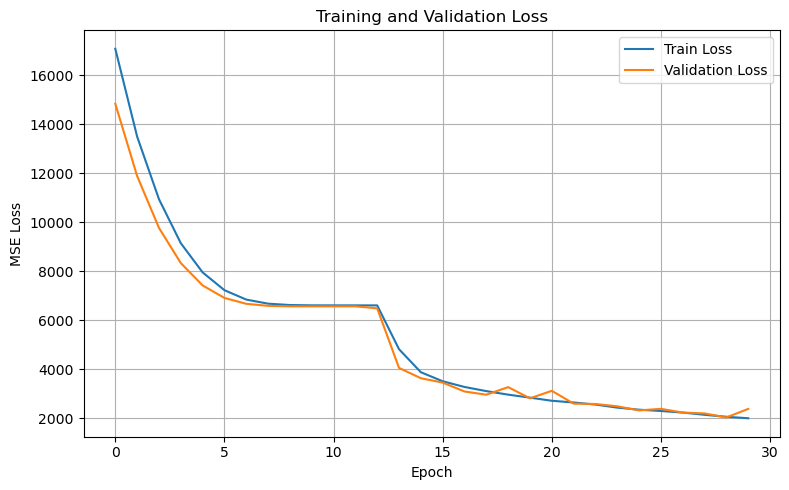

In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM_Multichannel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(xb)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * len(xb)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
# Plot Loss Curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Test Set Evaluation

Test RMSE (CNN+LSTM): 49.5580


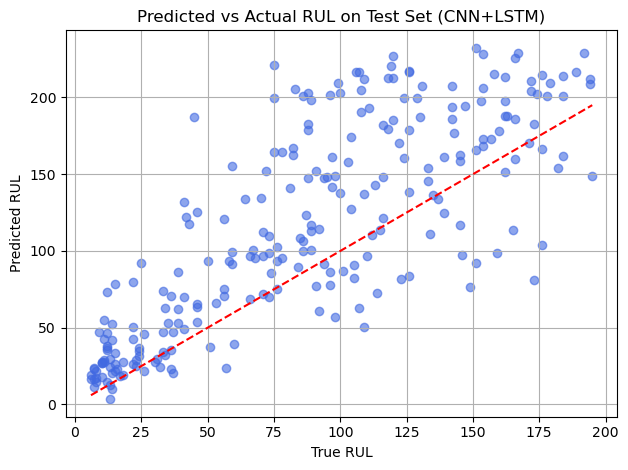

In [24]:
# === 6. Test Set Evaluation ===

# --- Load and process test data ---
test_df = pd.read_csv("test_FD004.txt", sep=' ', header=None)
test_df.drop(columns=[26, 27], inplace=True)
test_df.columns = column_names

# Normalize and clean sensor data
sensor_data_test = test_df[sensor_cols]
sensor_data_test_normalized = 2 * (sensor_data_test - sensor_min) / (sensor_max - sensor_min) - 1
sensor_data_test_clean = sensor_data_test_normalized.drop(columns=sensors_to_remove)
test_cleaned = test_df[['unit_number', 'time_in_cycles']].join(sensor_data_test_clean)

# Load true RUL values
true_rul = pd.read_csv("RUL_FD004.txt", sep=' ', header=None)
true_rul = true_rul.dropna(axis=1)
true_rul.columns = ['true_RUL']

# Prepare test features using last TW cycles per unit
X_test = []
for unit in test_cleaned['unit_number'].unique():
    unit_data = test_cleaned[test_cleaned['unit_number'] == unit].reset_index(drop=True)
    if len(unit_data) >= TW:
        window = unit_data.iloc[-TW:][sensor_feature_cols].values
    else:
        padding = np.zeros((TW - len(unit_data), len(sensor_feature_cols)))
        window = np.vstack((padding, unit_data[sensor_feature_cols].values))
    X_test.append(window)
X_test = np.array(X_test)  # (num_units, TW, num_features)
X_test = np.transpose(X_test, (0, 2, 1))  # (num_units, num_features, TW)
X_test = X_test[..., np.newaxis]          # (num_units, num_features, TW, 1)

# Convert to tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Predict with model
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()

# Compute RMSE
test_rmse = np.sqrt(mean_squared_error(true_rul['true_RUL'].values, y_test_pred))
print(f"Test RMSE (CNN+LSTM): {test_rmse:.4f}")

# Plot Actual vs Predicted RUL
plt.figure()
plt.scatter(true_rul['true_RUL'], y_test_pred, alpha=0.6, color='royalblue')
plt.plot([true_rul['true_RUL'].min(), true_rul['true_RUL'].max()],
         [true_rul['true_RUL'].min(), true_rul['true_RUL'].max()], 'r--')
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL")
plt.title("Predicted vs Actual RUL on Test Set (CNN+LSTM)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Results Comparison

# Conclusion

# References